<a href="https://colab.research.google.com/github/frank-morales2020/Cloud_curious/blob/master/mmlu_eval_openai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building an MMLU Eval

This notebook shows how to:
- Build and run an eval
- Load the results and into a Pandas Dataframe

We use the `evals.elsuite.basic.match:Match` Eval class here to check whether new completions match the correct answer. Under the hood, it will generate a completion with the choice of model for each prompt, check if the completion matches the true answer, then logs a result.

In [ ]:
!git clone https://github.com/openai/evals.git

In [ ]:
# Install, and download MMLU if you haven't already
%cd /content/evals/
%pip install -e . -q

In [ ]:
!curl -O https://people.eecs.berkeley.edu/~hendrycks/data.tar
!tar -xf data.tar
data_path = "data"

In [5]:
import pandas as pd
import os

# Assuming this notebook is in examples/
registry_path = os.path.join(os.getcwd(), "/content/evals/registry")
print(registry_path)

/content/evals/registry


In [6]:
# Build the prompts using Chat format. We support converting Chat conversations to text for non-Chat models

choices = ["A", "B", "C", "D"]
sys_msg = "The following are multiple choice questions (with answers) about {}."
def create_chat_prompt(sys_msg, question, answers, subject):
    user_prompt = f"{question}\n" + "\n".join([f"{choice}. {answer}" for choice, answer in zip(choices, answers)]) + "\nAnswer:"
    return [
        {"role": "system", "content": sys_msg.format(subject)},
        {"role": "user", "content": user_prompt}
    ]

def create_chat_example(question, answers, correct_answer):
    """
    Form few-shot prompts in the recommended format: https://github.com/openai/openai-python/blob/main/chatml.md#few-shot-prompting
    """
    user_prompt = f"{question}\n" + "\n".join([f"{choice}. {answer}" for choice, answer in zip(choices, answers)]) + "\nAnswer:"
    return [
        {"role": "system", "content": user_prompt, "name": "example_user"},
        {"role": "system", "content": correct_answer, "name": "example_assistant"},
    ]

In [8]:
data_path='/content/evals/data'

In [9]:
import yaml
subjects = sorted([f.split("_test.csv")[0] for f in os.listdir(os.path.join(data_path, "test")) if "_test.csv" in f])

registry_yaml = {}

for subject in subjects:
    subject_path = os.path.join(registry_path, "data", "mmlu", subject)
    os.makedirs(subject_path, exist_ok=True)

    # Create few-shot prompts
    dev_df = pd.read_csv(os.path.join(data_path, "dev", subject + "_dev.csv"), names=("Question", "A", "B", "C", "D", "Answer"))
    dev_df["sample"] = dev_df.apply(lambda x: create_chat_example(x["Question"], x[["A", "B", "C", "D"]], x["Answer"]), axis=1)
    few_shot_path = os.path.join(subject_path, "few_shot.jsonl")
    dev_df[["sample"]].to_json(few_shot_path, lines=True, orient="records")

    # Create test prompts and ideal completions
    test_df = pd.read_csv(os.path.join(data_path, "test", subject + "_test.csv"), names=("Question", "A", "B", "C", "D", "Answer"))
    test_df["input"] = test_df.apply(lambda x: create_chat_prompt(sys_msg, x["Question"], x[["A", "B", "C", "D"]], subject), axis=1)
    test_df["ideal"] = test_df.Answer
    samples_path = os.path.join(subject_path, "samples.jsonl")
    test_df[["input", "ideal"]].to_json(samples_path, lines=True, orient="records")

    eval_id = f"match_mmlu_{subject}"

    registry_yaml[eval_id] = {
        "id": f"{eval_id}.test.v1",
        "metrics": ["accuracy"]
    }
    registry_yaml[f"{eval_id}.test.v1"] = {
        "class": "evals.elsuite.basic.match:Match",
        "args": {
            "samples_jsonl": samples_path,
            "few_shot_jsonl": few_shot_path,
            "num_few_shot": 4,
        }
    }
registry_path = '/content'
with open(os.path.join(registry_path, "evals", "mmlu.yaml"), "w") as f:
    yaml.dump(registry_yaml, f)

In [ ]:
!pip install colab-env --upgrade -q
!pip install openai -q
import colab_env
import os
import openai
from openai import OpenAI
client = OpenAI(api_key = os.getenv("OPENAI_API_KEY"))

In [ ]:
from openai import OpenAI
client = OpenAI()

modellist=client.models.list()
modellist.data

In [ ]:
from datasets import load_dataset

# Choose one of the available configurations from the list provided in the traceback
config_name = "abstract_algebra"

# Load the dataset with the specified configuration
dataset = load_dataset("cais/mmlu", config_name=config_name)

In [46]:
# This will generate a JSONL which will record samples and logs and store it in /tmp/evallogs
#!oaieval gpt-3.5-turbo match_mmlu_anatomy

#!oaieval gpt-3.5-turbo GPT-model-text-detection ## 0.48


#!oaieval gpt-3.5-turbo arc
#!oaieval gpt-3.5-turbo marxist_philosophy_exam

# abstract-causal-reasoning-text
# arc
# belarusian-antonyms

#!oaieval gpt-3.5-turbo belarusian-antonyms
!oaieval gpt-3.5-turbo belarusian
# marxist_philosophy_exam


[2024-05-28 19:59:42,029] [registry.py:271] Loading registry from /content/evals/evals/registry/evals
[2024-05-28 19:59:42,990] [registry.py:271] Loading registry from /root/.evals/evals
[2024-05-28 19:59:42,996] [registry.py:160] eval 'belarusian' not found. Closest matches: ['belarusian-rhyme', 'belarusian-lexicon', 'belarusian-grammar', 'belarusian-synonyms', 'belarusian-proverbs']
Traceback (most recent call last):
  File "/usr/local/bin/oaieval", line 8, in <module>
    sys.exit(main())
  File "/content/evals/evals/cli/oaieval.py", line 304, in main
    run(args)
  File "/content/evals/evals/cli/oaieval.py", line 133, in run
    eval_spec is not None
AssertionError: Eval belarusian not found. Available: ['2d_movement', '2d_movement.dev.v0', '3d_globe_movement', '3d_globe_movement.dev.v0', '3d_object_manipulation', '3d_object_manipulation.dev.v0', 'Chinese_character_riddles', 'Chinese_character_riddles.dev.v0', 'GPT-model-text-detection', 'GPT-model-text-detection.dev.v0', 'Unfamil

<Axes: title={'center': 'Correctness of generated answers'}, xlabel='Correctness', ylabel='Count'>

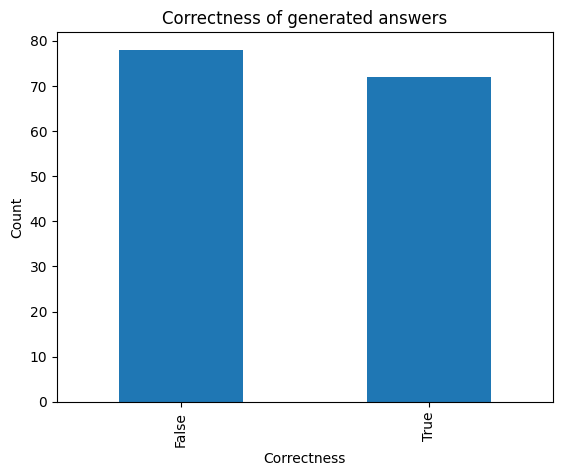

In [44]:
# How to process the log events generated by oaieval
#events = "/tmp/evallogs/{log_name}"
events = '/tmp/evallogs/240528195719EC57ZNJJ_gpt-3.5-turbo_belarusian-antonyms.jsonl'

with open(events, "r") as f:
    events_df = pd.read_json(f, lines=True)

matches_df = events_df[events_df.type == "match"].reset_index(drop=True)
matches_df = matches_df.join(pd.json_normalize(matches_df.data))
matches_df.correct.value_counts().plot.bar(title="Correctness of generated answers", xlabel="Correctness", ylabel="Count")

In [45]:
# Inspect samples
for i, r in pd.json_normalize(events_df[events_df.type == "sampling"].data).iterrows():
    print(f"Prompt: {r.prompt}")
    print(f"Sampled: {r.sampled}")
    print("-" * 25)

Prompt: [{'role': 'system', 'content': 'You will be prompted with two Belarusian words, separated by a comma. Are these words antonymous, at least in some of their commonly used meanings? Answer Y or N.'}, {'role': 'user', 'content': 'ганаровы, ганебны'}]
Sampled: ['Y']
-------------------------
Prompt: [{'role': 'system', 'content': 'You will be prompted with two Belarusian words, separated by a comma. Are these words antonymous, at least in some of their commonly used meanings? Answer Y or N.'}, {'role': 'user', 'content': 'спагада, жорсткасць'}]
Sampled: ['Y']
-------------------------
Prompt: [{'role': 'system', 'content': 'You will be prompted with two Belarusian words, separated by a comma. Are these words antonymous, at least in some of their commonly used meanings? Answer Y or N.'}, {'role': 'user', 'content': 'радасць, смутак'}]
Sampled: ['Y']
-------------------------
Prompt: [{'role': 'system', 'content': 'You will be prompted with two Belarusian words, separated by a comma.